In [1]:
import numpy as np
import torch
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 

In [3]:
kaggle_train = pd.read_csv('C:/datasets/digit-recognizer/train.csv').drop('label',axis=1).values
kaggle_labels = pd.read_csv('C:/datasets/digit-recognizer/train.csv')['label'].values

In [4]:
# not normalized images (0-255 pixels)
kaggle_train.dtype

dtype('int64')

In [5]:
kaggle_labels.dtype

dtype('int64')

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
kaggle_train = scaler.fit_transform(kaggle_train)

In [7]:
kaggle_train = torch.tensor(kaggle_train, dtype=torch.float32).view(42000,1,28,28)

In [8]:
kaggle_labels = torch.tensor(kaggle_labels, dtype=torch.int64)

In [9]:
kaggle_train.dtype, kaggle_labels.dtype

(torch.float32, torch.int64)

In [10]:
def normalize_dataset(image_dataset):
    if str(image_dataset.dtype)[:5] == 'torch' and len(image_dataset.shape) == 4:
        for i in range(image_dataset.shape[0]):
            new = image_dataset[i][0].flatten()
            new = 2*(new/255)-1
            image_dataset[i][0] = new.view(28,28) 
        return image_dataset
    else:
        raise Exception("IMAGE DATASET DOES NOT MEET REQUIREMENTS")

In [11]:
# kaggle_train = normalize_dataset(kaggle_train)

In [12]:
class KaggleDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.x_train = features
        self.y_train = labels
        
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]


In [13]:
from torchvision import datasets, transforms

train_transforms = transforms.Compose([transforms.RandomRotation(15), 
                                       transforms.ToTensor()
#                                         transforms.Normalize(0.5,0.5)
                                       ]) 
# transforms.RandomRotation(20),
# transforms.CenterCrop(28),

transform = transforms.Compose([
                                    transforms.ToTensor()
#                                  transforms.Normalize(0.5,0.5)
                               ])

kaggle_train = KaggleDataset(kaggle_train, kaggle_labels)

train = datasets.MNIST(root='data', train=True,
                                   download=True, transform=train_transforms)
train_valid = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

test = datasets.MNIST(root='data', train=False,
                                  download=True, transform=train_transforms)

test_valid = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.060952381

# obtain training indices that will be used for validation
num_kaggle_train = len(kaggle_train)
indices = list(range(num_kaggle_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_kaggle_train))
kaggle_train_idx, kaggle_train_valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
kaggle_train_sampler = SubsetRandomSampler(kaggle_train_idx)
kaggle_train_valid_sampler = SubsetRandomSampler(kaggle_train_valid_idx)

kaggle_train_loader = torch.utils.data.DataLoader(kaggle_train, batch_size=64,
    sampler=kaggle_train_sampler, num_workers=0)
kaggle_train_valid_loader = torch.utils.data.DataLoader(kaggle_train, batch_size=64, 
    sampler=kaggle_train_valid_sampler, num_workers=0)

In [15]:
valid_size = 0.064

# obtain training indices that will be used for validation
num_train = len(train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, train_valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
train_valid_sampler = SubsetRandomSampler(train_valid_idx)

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
    sampler=train_sampler, num_workers=0)
train_valid_loader = torch.utils.data.DataLoader(train_valid, batch_size=64, 
    sampler=train_valid_sampler, num_workers=0)

In [16]:
valid_size = 0.128

# obtain training indices that will be used for validation
num_test = len(test)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
test_idx, test_valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
test_sampler = SubsetRandomSampler(test_idx)
test_valid_sampler = SubsetRandomSampler(test_valid_idx)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
    sampler=test_sampler, num_workers=0)
test_valid_loader = torch.utils.data.DataLoader(test_valid, batch_size=64, 
    sampler=test_valid_sampler, num_workers=0)

In [17]:
# for training
len(kaggle_train_loader.sampler), len(train_loader.sampler), len(test_loader.sampler)

(39440, 56160, 8720)

In [18]:
# for validation
len(kaggle_train_valid_loader.sampler), len(train_valid_loader.sampler), len(test_valid_loader.sampler)

(2560, 3840, 1280)

In [19]:
iter1 = iter(kaggle_train_loader)
iter2 = iter(train_loader)
iter3 = iter(test_loader)

In [20]:
img1, lbl1 = next(iter1)

In [21]:
lbl1.to(torch.int64)

tensor([2, 4, 6, 8, 1, 0, 6, 1, 2, 5, 5, 2, 8, 2, 4, 8, 4, 6, 4, 5, 7, 5, 8, 2,
        4, 4, 3, 6, 7, 7, 1, 3, 8, 7, 6, 1, 7, 9, 5, 6, 6, 3, 3, 3, 7, 6, 6, 2,
        5, 5, 5, 2, 1, 7, 0, 5, 1, 1, 4, 7, 3, 4, 9, 3])

In [22]:
img2, lbl2 = next(iter2)

In [23]:
lbl2

tensor([0, 2, 4, 2, 5, 6, 8, 1, 9, 3, 4, 1, 1, 3, 7, 1, 4, 8, 5, 2, 4, 8, 4, 0,
        3, 2, 0, 9, 3, 6, 0, 9, 1, 1, 6, 5, 1, 5, 8, 7, 2, 9, 4, 0, 3, 6, 2, 3,
        7, 6, 3, 0, 2, 4, 1, 8, 9, 8, 7, 1, 0, 9, 2, 1])

In [24]:
img3, lbl3 = next(iter3)

In [25]:
lbl3

tensor([5, 2, 9, 6, 0, 8, 2, 8, 1, 6, 6, 3, 1, 4, 9, 6, 1, 2, 9, 1, 6, 0, 2, 7,
        0, 7, 6, 3, 3, 0, 7, 1, 0, 5, 7, 0, 8, 4, 9, 4, 8, 1, 4, 3, 1, 8, 0, 3,
        4, 4, 9, 8, 5, 9, 4, 1, 3, 7, 4, 0, 8, 6, 8, 2])

In [26]:
img1[0].flatten().min(), img1[0].flatten().mean(), img1[0].flatten().max(), img1[0].flatten().std() 

(tensor(0.), tensor(0.1422), tensor(1.), tensor(0.3146))

<AxesSubplot:ylabel='Count'>

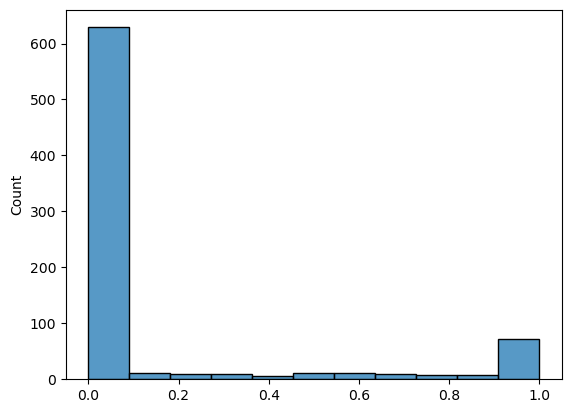

In [27]:
sns.histplot(img1[0].flatten())

In [28]:
img2[0].flatten().min(), img2[0].flatten().mean(), img2[0].flatten().max(), img2[0].flatten().std() 

(tensor(0.), tensor(0.1194), tensor(1.), tensor(0.2943))

<AxesSubplot:ylabel='Count'>

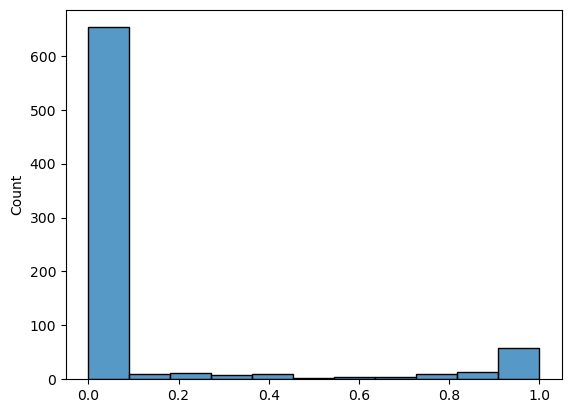

In [29]:
sns.histplot(img2[0].flatten())

In [30]:
img3[0].flatten().min(), img3[0].flatten().mean(), img3[0].flatten().max(), img3[0].flatten().std() 

(tensor(0.), tensor(0.1854), tensor(1.), tensor(0.3541))

<AxesSubplot:ylabel='Count'>

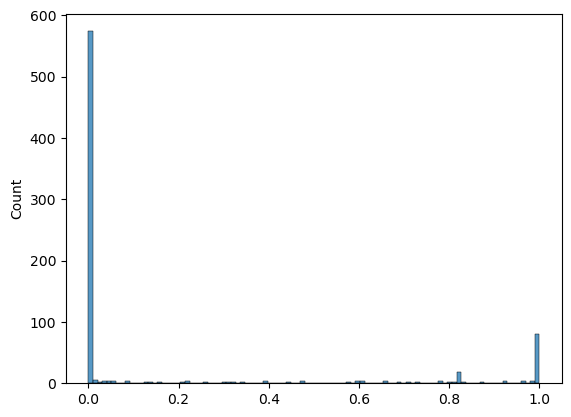

In [31]:
sns.histplot(img3[0].flatten())

In [32]:
mean_mean_of_batch = []
mean_std_of_batch = []
for i in range(img1.shape[0]):
    mean_mean_of_batch.append(img1[i][0].mean())
    mean_std_of_batch.append(img1[i][0].std())
    if i < 5:
        print(img1[i][0].min(), img1[i][0].mean(), img1[i][0].max(), img1[i][0].std())
print("============================")
print(f"mean_mean_of_batch: {np.array(mean_mean_of_batch).mean()}, mean_std_of_batch: {np.array(mean_std_of_batch).mean()}")

tensor(0.) tensor(0.1422) tensor(1.) tensor(0.3146)
tensor(0.) tensor(0.1435) tensor(1.) tensor(0.3225)
tensor(0.) tensor(0.1528) tensor(1.) tensor(0.3282)
tensor(0.) tensor(0.1050) tensor(1.) tensor(0.2779)
tensor(0.) tensor(0.1180) tensor(1.) tensor(0.3011)
mean_mean_of_batch: 0.12817570567131042, mean_std_of_batch: 0.30053800344467163


In [33]:
mean_mean_of_batch = []
mean_std_of_batch = []
for i in range(img2.shape[0]):
    mean_mean_of_batch.append(img2[i][0].mean())
    mean_std_of_batch.append(img2[i][0].std())
    if i < 5:
        print(img2[i][0].min(), img2[i][0].mean(), img2[i][0].max(), img2[i][0].std())
print("============================")
print(f"mean_mean_of_batch: {np.array(mean_mean_of_batch).mean()}, mean_std_of_batch: {np.array(mean_std_of_batch).mean()}")

tensor(0.) tensor(0.1194) tensor(1.) tensor(0.2943)
tensor(0.) tensor(0.2007) tensor(1.) tensor(0.3778)
tensor(0.) tensor(0.1276) tensor(1.) tensor(0.3090)
tensor(0.) tensor(0.1949) tensor(1.) tensor(0.3737)
tensor(0.) tensor(0.1099) tensor(1.) tensor(0.2817)
mean_mean_of_batch: 0.12288665771484375, mean_std_of_batch: 0.29408401250839233


In [34]:
mean_mean_of_batch = []
mean_std_of_batch = []
for i in range(img3.shape[0]):
    mean_mean_of_batch.append(img3[i][0].mean())
    mean_std_of_batch.append(img3[i][0].std())
    if i < 5:
        print(img3[i][0].min(), img3[i][0].mean(), img3[i][0].max(), img3[i][0].std())
print("============================")
print(f"mean_mean_of_batch: {np.array(mean_mean_of_batch).mean()}, mean_std_of_batch: {np.array(mean_std_of_batch).mean()}")

tensor(0.) tensor(0.1854) tensor(1.) tensor(0.3541)
tensor(0.) tensor(0.1735) tensor(1.) tensor(0.3574)
tensor(0.) tensor(0.0931) tensor(1.) tensor(0.2550)
tensor(0.) tensor(0.1964) tensor(1.) tensor(0.3589)
tensor(0.) tensor(0.1065) tensor(0.9961) tensor(0.2641)
mean_mean_of_batch: 0.14117412269115448, mean_std_of_batch: 0.3122362494468689


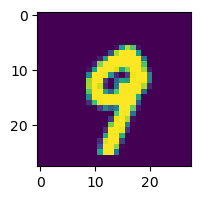

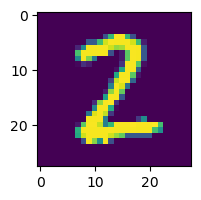

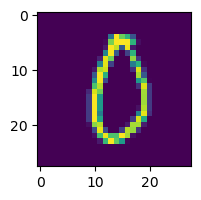

In [35]:
# show 3 random images of data set
for i in (np.random.rand(3)*100).astype('int'):
    plt.figure(figsize=(2, 2))
    plt.imshow(kaggle_train_loader.dataset.x_train[i].squeeze(), interpolation='nearest')
    plt.show()

In [36]:
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 20, 2, padding=1)
        self.norm1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 40, 2, padding=1)
        self.norm2 = nn.BatchNorm2d(40)
        
        self.conv3 = nn.Conv2d(40, 60, 2, padding=1)
        self.norm3 = nn.BatchNorm2d(60)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(60 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = x.view(x.shape[0],1,28,28)
        
        x = self.norm1(self.pool(F.relu(self.conv1(x))))
        
        x = self.dropout(x)
        
        x = self.norm2(self.pool(F.relu(self.conv2(x))))
        
        x = self.dropout(x)
        
        x = self.norm3(self.pool(F.relu(self.conv3(x))))
        

        x = self.dropout(x)

        # flatten image input
        x = x.view(-1, 60 * 4 * 4)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = F.relu(self.fc2(x))

        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        
        embedding = x.clone()

        x = self.dropout(x)

        x = F.log_softmax(self.fc4(x), dim=1)

        return x, embedding

# create a complete CNN
model = Net().to(device)
print(model)


Net(
  (conv1): Conv2d(1, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 60, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [37]:
model.load_state_dict(torch.load('MNIST-CNN.pt'))

<All keys matched successfully>

In [38]:
# initialize lists to monitor test loss and accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in kaggle_train_valid_loader:
    target = torch.tensor(np.array(target)).to(torch.int64)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))[0]
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print('Kaggle train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Kaggle train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nKaggle train (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print('======================================')

############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################

# initialize lists to monitor test loss and accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in train_valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))[0]
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTrain Accuracy (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('=====================================')

############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################


# initialize lists to monitor test loss and accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in test_valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))[0]
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print metrics

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Kaggle train Accuracy of     0: 100% (259/259)
Kaggle train Accuracy of     1: 99% (281/283)
Kaggle train Accuracy of     2: 100% (245/245)
Kaggle train Accuracy of     3: 100% (283/283)
Kaggle train Accuracy of     4: 100% (256/256)
Kaggle train Accuracy of     5: 100% (245/245)
Kaggle train Accuracy of     6: 100% (243/243)
Kaggle train Accuracy of     7: 100% (255/255)
Kaggle train Accuracy of     8: 99% (261/262)
Kaggle train Accuracy of     9: 100% (229/229)

Kaggle train (Overall): 99% (2557/2560)
Train Accuracy of     0: 99% (389/391)
Train Accuracy of     1: 100% (428/428)
Train Accuracy of     2: 100% (388/388)
Train Accuracy of     3: 99% (384/385)
Train Accuracy of     4: 100% (372/372)
Train Accuracy of     5: 99% (343/345)
Train Accuracy of     6: 100% (347/347)
Train Accuracy of     7: 99% (417/421)
Train Accuracy of     8: 100% (376/376)
Train Accuracy of     9: 99% (386/387)

Train Accuracy (Overall): 99% (3830/3840)
Test Accuracy of     0: 100% (134/134)
Test Accuracy 

In [39]:
from torch.nn import CosineSimilarity

def cosine_sim(x,y):
    cos = CosineSimilarity(dim=1, eps=1e-6)
    coef_of_similarity = cos(x.view(1,-1).float(), y.view(1,-1).float())
    return coef_of_similarity

In [40]:
target.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [41]:
# indexes of all numbers and calculation of vector similarity between all similar(by image) numbers
for class_number in target.unique():
    listof = (target == class_number).nonzero(as_tuple=True)[0].tolist()
    for i in range(len(listof)):
        if i >= 1:
            print(f' cos sim between {target[listof[i-1]]} and {target[listof[i]]} is {cosine_sim(model(data[listof[i-1]].cuda())[0], model(data[listof[i]].cuda())[0])}')

 cos sim between 0 and 0 is tensor([0.9958], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 0 and 0 is tensor([0.9933], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 0 and 0 is tensor([0.9980], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 0 and 0 is tensor([0.9974], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 0 and 0 is tensor([0.9987], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 1 is tensor([0.9815], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 1 is tensor([0.9895], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 1 is tensor([0.9995], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 1 is tensor([0.9998], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 1 is tensor([0.9982], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 2 and 2 is tensor([0.9921], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 2 and 2 is tensor([0.9958], device='c

In [42]:
# cos sim between different numbers
for i in range(len(target)):
    if i >= 1:
        print(f' cos sim between {target[target[i-1]]} and {target[target[i]]} is {cosine_sim(model(data[target[i-1]].cuda())[0], model(data[target[i]].cuda())[0])}')

 cos sim between 3 and 6 is tensor([0.7629], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 6 is tensor([0.9986], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 6 is tensor([0.9934], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 1 is tensor([0.8174], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 6 is tensor([0.8354], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 6 is tensor([1.], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 7 is tensor([0.7061], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 7 and 1 is tensor([0.9219], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 1 and 6 is tensor([0.8174], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 5 is tensor([0.9110], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 5 and 6 is tensor([0.9110], device='cuda:0', grad_fn=<SumBackward1>)
 cos sim between 6 and 3 is tensor([0.7839], device='cuda:

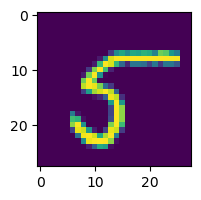

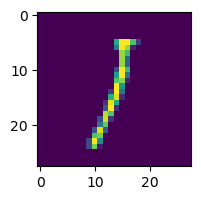

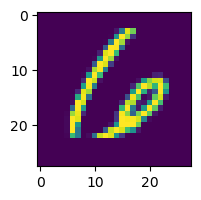

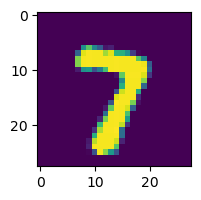

In [43]:
plt.figure(figsize=(2, 2))
plt.imshow(data[2].view(28,28), interpolation='nearest')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(data[3].view(28,28), interpolation='nearest')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(data[5].view(28,28), interpolation='nearest')
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(data[7].view(28,28), interpolation='nearest')
plt.show()

In [44]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
#     if version == "MNIST":
#         ax2.set_yticklabels(np.arange(10))
#     elif version == "Fashion":
#         ax2.set_yticklabels(['T-shirt/top',
#                             'Trouser',
#                             'Pullover',
#                             'Dress',
#                             'Coat',
#                             'Sandal',
#                             'Shirt',
#                             'Sneaker',
#                             'Bag',
#                             'Ankle Boot'], size='small');
#     ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Predicted Digit = 6


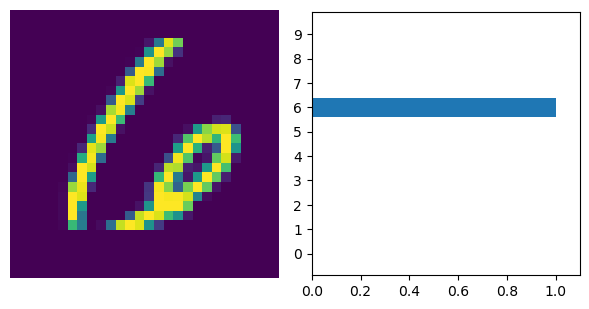

In [46]:
img = data[5].view(1,784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())[0]

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps).cpu()
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Predicted Digit = 7


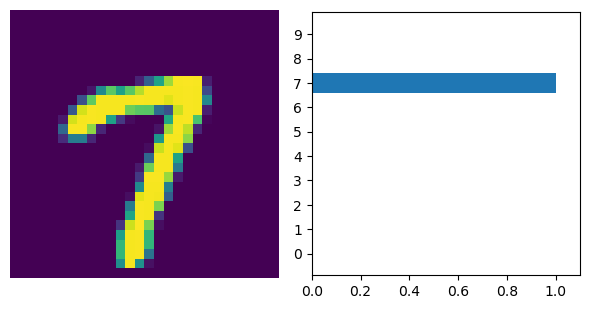

In [45]:
images, labels = next(iter1)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())[0]

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps).cpu()
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)